In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
import sys

sys.path.append('../../')
from utils.metrics import calculate_metric

### Evaluation


In [2]:
CHRISTMAS_QRELS_FILE = "../qrels_files/christmas_movies.txt"
ROMANCE_TEEN_QRELS_FILE = "../qrels_files/romance_teen.txt"
SPACE_QRELS_FILE = "../qrels_files/space_movies.txt"

CHRISTMAS_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=score%20*&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20%22christmas%20eve%22%20advent&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

SPACE_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

ROMANCE_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=score%20*&indent=true&q.op=OR&q=romance%20teen%5E3.0%20crush%20heart-break%5E3.0%20%22in%20love%22%5E2.0%20high-school%5E2.0%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"


In [3]:
info = {
    "christmas_movies": {
        "query_url": CHRISTMAS_QUERY_URL,
        "qrels_file": CHRISTMAS_QRELS_FILE,
    },
    "space_movies": {
        "query_url": SPACE_QUERY_URL,
        "qrels_file": SPACE_QRELS_FILE,
    },
    "romance_teen_movies": {
        "query_url": ROMANCE_TEEN_QUERY_URL,
        "qrels_file": ROMANCE_TEEN_QRELS_FILE,
    }
}

In [4]:
""" # Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(paths['qrels_file']).readlines()))

# Get query results from Solr instance
results = requests.get(paths['query_url']).json()["response"]["docs"] """

' # Read qrels to extract relevant documents\nrelevant = list(map(lambda el: el.strip(), open(paths[\'qrels_file\']).readlines()))\n\n# Get query results from Solr instance\nresults = requests.get(paths[\'query_url\']).json()["response"]["docs"] '

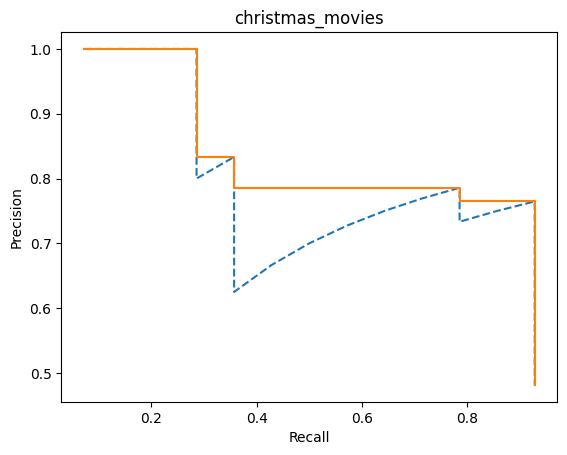

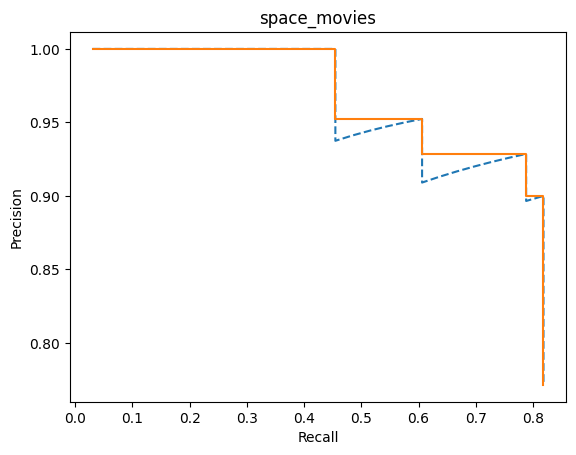

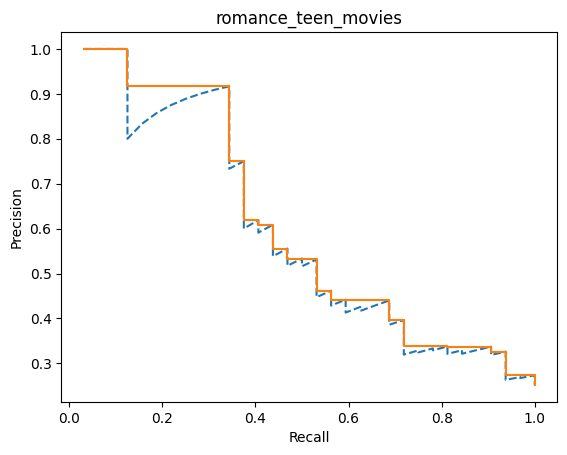

In [5]:
DEBUG = False

average_precisions = []

for movie_type, paths in info.items():
    # Read qrels to extract relevant documents
    relevant = list(map(lambda el: el.strip(), open(paths['qrels_file']).readlines()))

    # Get query results from Solr instance
    results = requests.get(paths['query_url']).json()["response"]["docs"]
    

    # Define metrics to be calculated
    evaluation_metrics = {
        "ap": "Average Precision", "ap10": "Average Precision (AP@10)",
        "p10": "Precision at 10 (P@10)", "p15": "Precision at 15 (P@15)",
        "ia": "Individual Assessment (IA@10)"
    }

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame(
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ],
        columns=["Metric", "Value"]
    )

    average_precisions.append(calculate_metric("ap", results, relevant))

    if not DEBUG:
        with open(f"../results/{movie_type}/results.tex", "w") as tf:
            tf.write(df.style.to_latex())


    # PRECISION-RECALL CURVE
    # Calculate precision and recall values as we move down the ranked list
    precision_values = [
        len([doc for doc in results[:idx] if doc["tconst"] in relevant]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([doc for doc in results[:idx] if doc["tconst"] in relevant]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    # Plot precision-recall curve
    fig, ax = plt.subplots(1, 1)
    ax.plot(recall_values, precision_values, '--C0')
    decreasing_max_precision = np.maximum.accumulate(precision_values[::-1])[::-1]
    ax.step(recall_values, decreasing_max_precision, '-C1')
    plt.title(f"{movie_type}")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    if not DEBUG:
        plt.savefig(f"../results/{movie_type}/precision_recall.pdf")

data = [
    ["Mean Average Precision", calculate_metric("map", average_precisions)],
]
df = pd.DataFrame(data=data, columns=["Metric", "Value"])

if not DEBUG:
    with open("../results/map.tex", "w") as tf:
        tf.write(df.style.to_latex())